# Orqviz demo - Using the Fourier transform

This notebook demonstrates how to use the discrete Fourier transform tool in orqviz to analyze quantum circuits. This example uses the *Quantum Approximate Optimization Algorithm* (QAOA).

You can treat it as a light-weight intro to methods that we described in more details in the paper titled ["Connecting the Hamiltonian structure to the QAOA energy and Fourier landscape structure"](https://arxiv.org/abs/2305.13594).

Fourier transform is used to isolate the frequencies of cosine and sine wave components used to make up a loss function. 

<div class="alert alert-block alert-info">
To execute this notebook, you will need to install: numpy, matplotlib, orquestra-core, and orqviz.
</div>

Links to Orquestra packages:
- [orquestra-core](https://github.com/zapatacomputing/orquestra-core)
- [orqviz](https://github.com/zapatacomputing/orqviz)

#### Version Information

| __Software__     | __Version__ |
| ---------------- | ----------- |
| numpy            | 1.22.3      |
| orquestra-core   | 0.9.0       |
| matplotlib       | 3.5.1       |

Let's get started!

In [1]:
import numpy as np
import orqviz
import matplotlib.pyplot as plt
from orquestra.quantum.operators import PauliTerm, PauliSum
from orquestra.vqa.algorithms import QAOA
from orquestra.integrations.cirq.simulator import CirqSimulator

/Users/michalstechly/.pyenv/versions/2023-05-24-qaoa-dario/lib/python3.8/site-packages/orquestra/integrations/cirq/simulator/_qsim_simulator.py:13: UserWarning: qsimcirq is not imported
  warnings.warn("qsimcirq is not imported")


In [2]:
np.random.seed(42)

## Simple cosine

Let's start with a simple example: loss function is a simple cosine function with frequency 3.

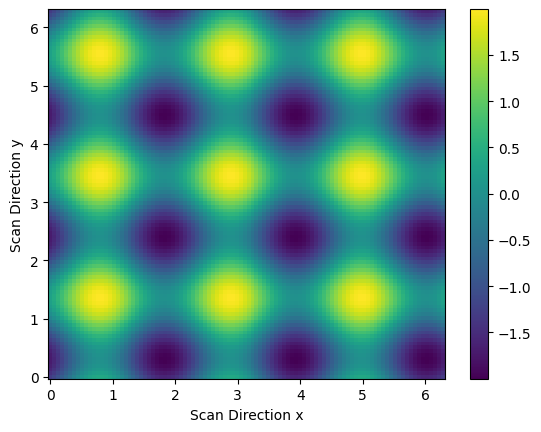

In [3]:
def loss_function(pars):
    return np.sum(np.cos(3 * pars))


n_params = 2
params = np.random.uniform(-np.pi, np.pi, size=n_params)
dir1 = np.array([1.0, 0.0])
dir2 = np.array([0.0, 1.0])
end_points = (0, 2 * np.pi)

res = 100
scan2D_result = orqviz.scans.perform_2D_scan(
    params,
    loss_function,
    direction_x=dir1,
    direction_y=dir2,
    n_steps_x=res,
    end_points_x=end_points,
)
orqviz.scans.plot_2D_scan_result(scan2D_result)

plt.show()
plt.clf()
plt.close()

Just like we expect: it is periodic with each period repeating about 3 times across the 0 - 2pi range. Now, let's run Fourier on it.

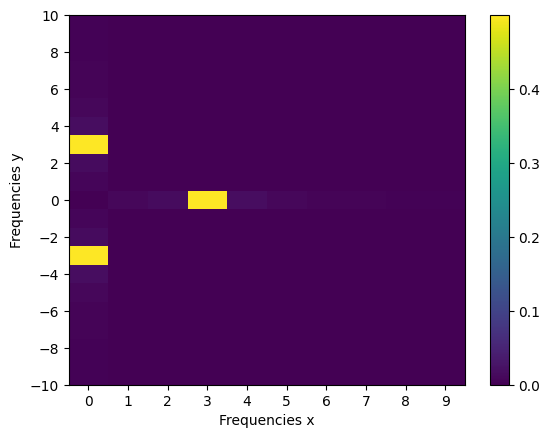

In [4]:
fourier_result = orqviz.fourier.scan_2D_fourier(
    params,
    loss_function,
    direction_x=dir1,
    direction_y=dir2,
    n_steps_x=res,
    end_points_x=end_points,
)
orqviz.fourier.plot_2D_fourier_result(fourier_result, max_freq_x=10, max_freq_y=10)

Note that because the output of DFT is complex, only the magnitude of the complex number is shown in the plot. This means that the phase of the input function will not affect the plot at all. Also note that we're plotting only positive frequencies for x direction and both positive and negative in y direction. For the sake of this notebook you can ignore any negative frequencies. We tried our best to explain it [section IIIA of our paper](https://arxiv.org/abs/2305.13594). If you'd like to see the full spectrum you can set `show_full_spectrum=True` in `plot_2D_fourier_result`.

Since the function is a simple cosine in both the x and y direction, we see a single peak in both directions reflected in the Fourier result at the exact location of 3.

The fact that all the non-zero values are concentrated near the boundaries (where either the x or the y component of the frequency is 0) mean that there aren't any cos(x) * cos(y) components of this pure cosine function.

Now, let's try DFT on some quantum circuits!

In [5]:
def plot_function_and_fourier_transform(hamiltonian: PauliSum, res: int, fourier_limits=20, n_layers=1, dir1=np.array([1.0, 0.0]), dir2=np.array([0.0, 1.0]), return_fourier_result=False):
    params = np.random.uniform(-np.pi, np.pi, size=n_layers * 2)
    end_points = (0, 2 * np.pi)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    
    qaoa = QAOA.default(cost_hamiltonian=hamiltonian, n_layers=n_layers)
    runner = CirqSimulator()
    loss_function = qaoa.get_cost_function(runner)

    scan2D_result = orqviz.scans.perform_2D_scan(
        params,
        loss_function,
        direction_x=dir1,
        direction_y=dir2,
        n_steps_x=res,
        end_points_x=end_points,
    )
    orqviz.scans.plot_2D_scan_result(scan2D_result, fig, ax1)

    fourier_result = orqviz.fourier.perform_2D_fourier_transform(scan2D_result, end_points, end_points)

    orqviz.fourier.plot_2D_fourier_result(fourier_result, max_freq_x=fourier_limits, max_freq_y=fourier_limits, fig=fig, ax=ax2)
    plt.show()
    plt.clf()
    plt.close()

    if return_fourier_result:
        return fourier_result


## Fourier transform on quantum circuits

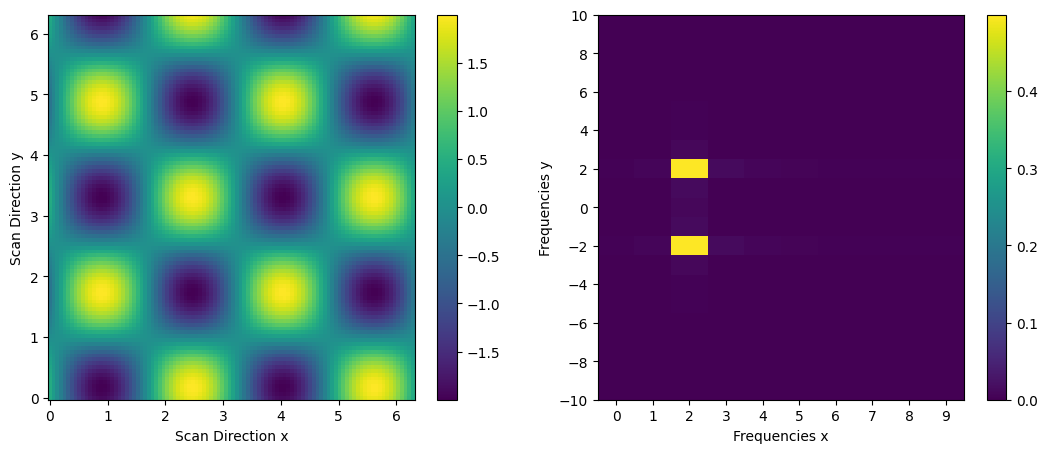

In [6]:
sum_hamiltonian = PauliTerm("Z0") + PauliTerm("Z1")
fourier_result = plot_function_and_fourier_transform(sum_hamiltonian, res=100, fourier_limits=10) 

The first plot is of the landscape of the function, the second one is of the result of the Fourier transform. We can see that the prominent component of this loss function contains a cos(x) and cos(y) terms multiplied together, each with a frequency of 2.

Again, don't worry about the negative frequencies.

Now, we'll try with a funkier hamiltonian.

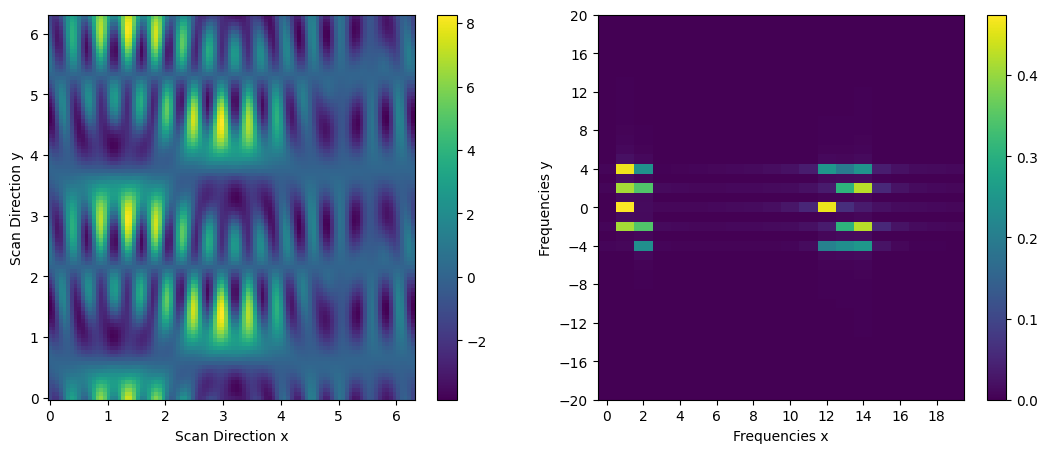

In [7]:
hamiltonian_1 = (
    (-2.75) * PauliTerm("Z0")
    + (-3.25) * PauliTerm("Z1")
    + (3.75) * PauliTerm("Z0")*PauliTerm("Z1")
)

plot_function_and_fourier_transform(hamiltonian_1, res=100)

This hamiltonian has 2 clusters of activity at 2 different frequencies around 2 and 13 in the x-direction. You can see this reflected in the graph, where in the x-direction, there is a higher frequency ripple by the contrasting colours and a lower frequency one that goes up and down.

This is one way that Fourier transforms can help us analyze Hamiltonians - by looking at the plot on the left, this appears to be a quite complicated landscape. However, we can see in the Fourier landscape that it has some inherent structure that we can analyze.

If you're interested, we analyzed this Hamiltonian more in [our paper](https://arxiv.org/abs/2305.13594).

## Multidimensional loss functions

We can try using Fourier to help visualize loss functions with more than two parameters. This is done by using orqviz to get a 2D cross section of the loss function landscape and running a 2D Fourier transform on that slice. 

We will try this out with our previous hamiltonian with 2-layer QAOA, leading to a loss function with 4 total parameters. We will take 3 of these random slices to see if any patterns show up in the Fourier results.

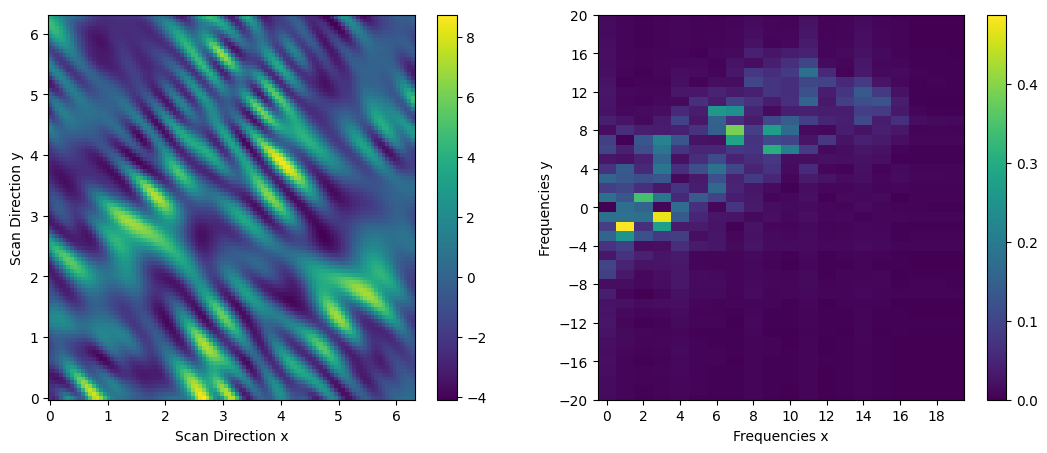

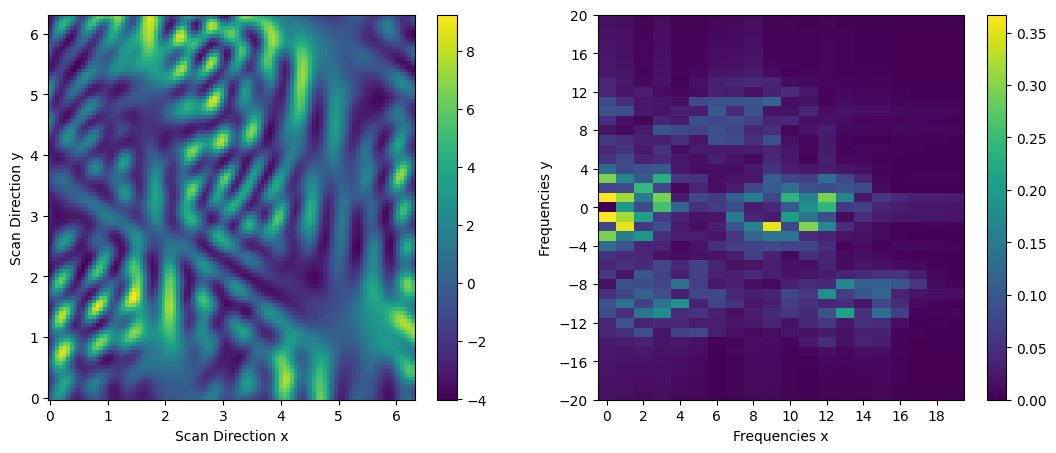

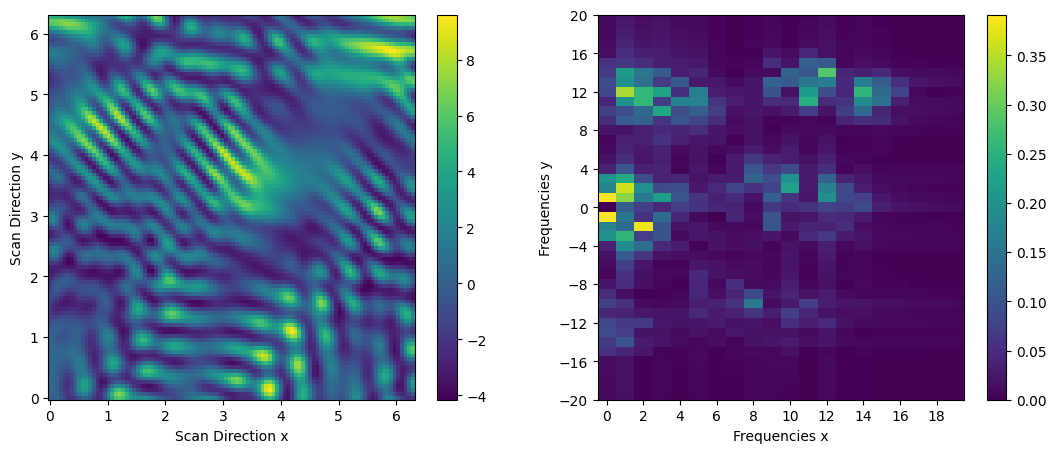

In [8]:
n_layers = 2 
n_params = n_layers * 2

fourier_results = []

for seed in range(3):
    np.random.seed(seed)
    dir1 = orqviz.geometric.get_random_normal_vector(n_params)
    dir2 = orqviz.geometric.get_random_orthonormal_vector(dir1)
    fourier_result = plot_function_and_fourier_transform(hamiltonian_1, res=100, fourier_limits=20, n_layers=n_layers, dir1=dir1, dir2=dir2, return_fourier_result=True)
    fourier_results.append(fourier_result)

We can try doing postprocessing like taking mean and variance of these plots to see if any patterns emerge, which might tell us some information about a hamiltonian. This will probably look more interesting if we have more slices to average over.

However, this part is definitely heavily underresearched, so we don't really know what's a good way to look at these specific plots – if you want, you can explore 

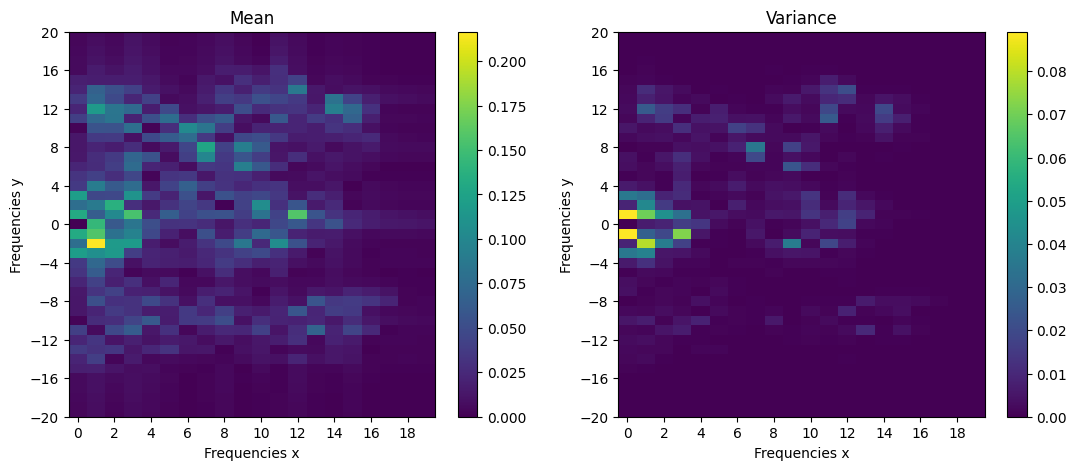

In [9]:
fourier_values = [result.values for result in fourier_results]
mean = np.mean(fourier_values, axis=0)
variance = np.var(fourier_values, axis=0)
mean_plot = orqviz.fourier.FourierResult(mean, fourier_result.end_points_x, fourier_result.end_points_y)
variance_plot = orqviz.fourier.FourierResult(variance, fourier_result.end_points_x, fourier_result.end_points_y)
max_freq = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
orqviz.fourier.plot_2D_fourier_result(mean_plot, max_freq_x=max_freq, max_freq_y=max_freq, fig=fig, ax=ax1)
ax1.set_title("Mean")
orqviz.fourier.plot_2D_fourier_result(variance_plot, max_freq_x=max_freq, max_freq_y=max_freq, fig=fig, ax=ax2)
ax2.set_title("Variance")

plt.show()
plt.clf()
plt.close()

## Denoising

Finally, we will showcase a possible application of the Fourier transform by sampling removing noise from a noisy loss function.

This is done by truncating the frequencies below a certain threshold, then doing an inverse Fourier transform. This restores the original landscape but without the contributions from high frequency components (which are caused by noise).

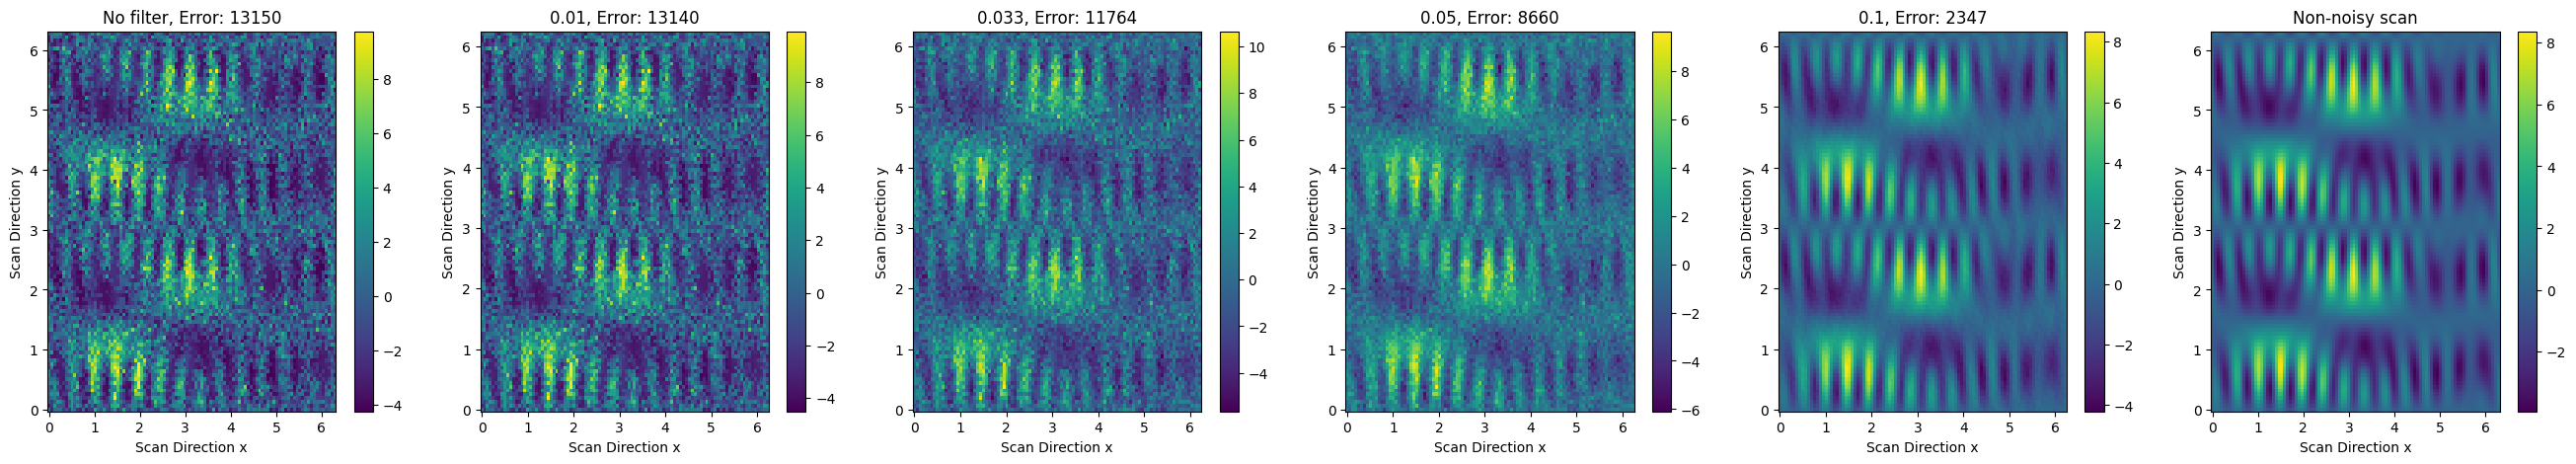

In [10]:
import copy

hamiltonian_1 = (
    (-2.75) * PauliTerm("Z0")
    + (-3.25) * PauliTerm("Z1")
    + (3.75) * PauliTerm("Z0")*PauliTerm("Z1")
)

n_shots = 10

def noisy_loss_function(params):
    qaoa = QAOA.default(cost_hamiltonian=hamiltonian_1, n_layers=1, use_exact_expectation_values=False, n_shots=n_shots)
    runner = CirqSimulator()
    cost_function = qaoa.get_cost_function(runner)

    return cost_function(params)


def exact_loss_function(params):
    qaoa = QAOA.default(cost_hamiltonian=hamiltonian_1, n_layers=1, use_exact_expectation_values=True)
    runner = CirqSimulator()
    cost_function = qaoa.get_cost_function(runner)
    return cost_function(params)


n_params = 2
params = np.random.uniform(-np.pi, np.pi, size=n_params)
dir1 = np.array([1.0, 0.0])
dir2 = np.array([0.0, 1.0])
end_points = (0, 2 * np.pi)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(33, 5))


res = 100
fourier_res = res
filter_thresholds = [0.01, 0.033, 0.05, 0.1]  # amplitude filtering threshold


def filter(values: np.ndarray, threshold) -> np.ndarray:
    # everything less than threshold * max amplitude becomes 0.
    filtered = copy.copy(values)
    filtered[np.abs(filtered) < np.max(np.abs(filtered)) * threshold] = 0
    return filtered


scan2D_result = orqviz.scans.perform_2D_scan(params, noisy_loss_function, direction_x=dir1, direction_y=dir2, n_steps_x=res, end_points_x=end_points)
orqviz.scans.plot_2D_scan_result(scan2D_result, fig, ax1)

# For efficiency, reuse the `scan2D_result`:

# fourier_values = np.fft.rfft2(scan2D_result.values, norm="forward")
# fourier_result = orqviz.fourier.FourierResult(fourier_values, end_points, end_points)
fourier_result = orqviz.fourier.perform_2D_fourier_transform(scan2D_result, end_points, end_points)
perfect_scan2D_result = orqviz.scans.perform_2D_scan(params, exact_loss_function, direction_x=dir1, direction_y=dir2, n_steps_x=res, end_points_x=end_points)
orqviz.scans.plot_2D_scan_result(perfect_scan2D_result, fig, ax6)
ax6.set_title("Non-noisy scan")

for threshold, ax in zip(filter_thresholds, [ax2, ax3, ax4, ax5]):
    filtered_values = filter(fourier_result.values, threshold)
    filtered_fourier_result = orqviz.fourier.FourierResult(filtered_values, end_points, end_points)
    inverse_result = orqviz.fourier.inverse_fourier(filtered_fourier_result)

    orqviz.fourier.plot_inverse_fourier_result(inverse_result, fig=fig, ax=ax)
    breakpoint()
    ax.set_title(f"{threshold}, Error: {int(np.abs(inverse_result.values - perfect_scan2D_result.values).sum())}")

ax1.set_title(f"No filter, Error: {int(np.abs(scan2D_result.values - perfect_scan2D_result.values).sum())}")

plt.show()
plt.clf()
plt.close()

We can see that filtering out all frequencies less than 0.0033 of the maximum coefficient's magnitude makes the landscape look "smooth" like the one that was scanned without noise.

After writing this example we later learned that this method has been also described in the following papers: https://arxiv.org/abs/2206.08811 and https://arxiv.org/abs/2208.05958, so if you'd like to learn more in-depth about it, that's the right place!

## Some tips on interpreting results

You have read this tutorial, and now you are ready to venture out into the spooky landscape of trying out Fourier on your own. Here are some tips that may help you:

### 1. Artifacts from low resolution on input scan

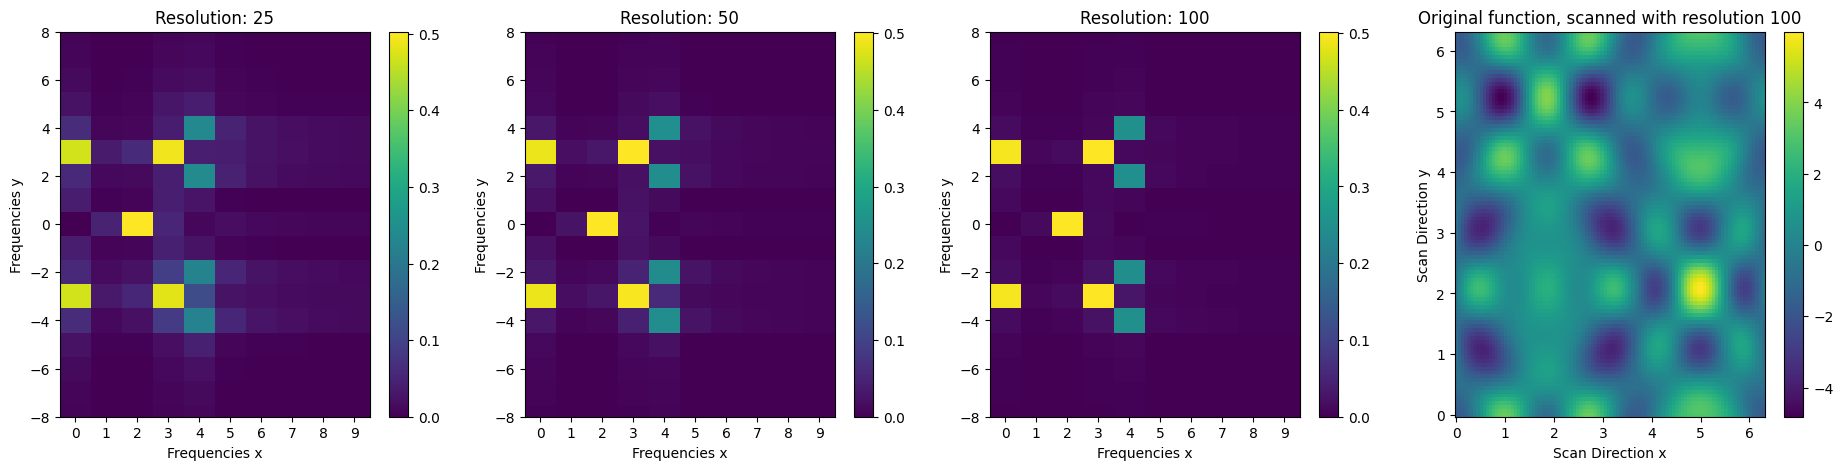

In [11]:
interesting_hamiltonian = PauliTerm("Z0") + PauliTerm("Z1") + 0.5*PauliTerm("Z0") * PauliTerm("Z2")
n_layers = 1
params = np.random.uniform(-np.pi, np.pi, size=n_layers * 2)
end_points = (0, 2 * np.pi)
dir1=np.array([1.0, 0.0])
dir2=np.array([0.0, 1.0])
resolutions = [25, 50, 100]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(23, 5))

def loss_function(params: np.ndarray) -> float:
    term_1 = np.cos(2 * params[0])
    term_2 = np.cos(3 * params[1])
    term_3 = np.cos(4 * params[0]) * np.cos(-2 * params[1])
    term_4 = np.cos(3 * params[0]) * 2*np.cos(3 * params[1])
    term_5 = np.cos(4 * params[0]) * np.cos(4 * params[1])
    return term_1 + term_2 + term_3 + term_4 + term_5
    qaoa = QAOA.default(cost_hamiltonian=hamiltonian_1, n_layers=n_layers)
    runner = CirqSimulator()
    cost_function = qaoa.get_cost_function(runner)
    return cost_function(params)


for resolution, ax in zip(resolutions, [ax1, ax2, ax3]):
    fourier_result = orqviz.fourier.scan_2D_fourier(params, loss_function, direction_x=dir1, direction_y=dir2, n_steps_x=resolution, end_points_x=end_points)

    orqviz.fourier.plot_2D_fourier_result(fourier_result, max_freq_x=10, max_freq_y=8, fig=fig, ax=ax)
    ax.set_title(f"Resolution: {resolution}")

scan2D_result = orqviz.scans.perform_2D_scan(params, loss_function, direction_x=dir1, direction_y=dir2, n_steps_x=resolutions[-1], end_points_x=end_points)
orqviz.scans.plot_2D_scan_result(scan2D_result, fig, ax4)
ax4.set_title(f"Original function, scanned with resolution {resolutions[-1]}")

plt.show()
plt.clf()
plt.close()

At a frequency of 100, it is pretty clear that this hamiltonian isn't that complicated - it is only made up of 5 main frequency components. At lower frequencies such as 25, however, you see streaks radiating outward from the main components, and it is much harder to isolate the main frequencies. These are false frequencies that are only shown due to imprecision associated with the limited sampling resolution. As the resolution of the input goes to infinity, the discrete fourier transform result goes to perfectly capturing the input frequencies.

### 2. Artifacts from non-integer frequencies

As shown in previous examples, the Fourier transform perfectly isolates spikes when input loss function has a integer number of periods over the scan range of 0 to 2pi. However, when the input loss function has a non-integer frequency, the Fourier transform produces interesting artifacts. We will try the following with a simple cosine function whose frequency is 3.5.

In [ ]:
def loss_function(pars):
    return np.sum(np.cos(3.5 * pars))


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(28, 5))
n_params = 2
params = np.random.uniform(-np.pi, np.pi, size=n_params)
dir1 = np.array([1.0, 0.0])
dir2 = np.array([0.0, 1.0])
end_points = (0, 2*np.pi)

input_resolutions = [25, 50, 100, 1000]

for resolution, ax in zip(input_resolutions, [ax1, ax2, ax3, ax4]):
    fourier_result = orqviz.fourier.scan_2D_fourier(params, loss_function, direction_x=dir1, direction_y=dir2, n_steps_x=resolution, end_points_x=end_points)
    orqviz.fourier.plot_2D_fourier_result(fourier_result, max_freq_x=10, max_freq_y=10, fig=fig, ax=ax)
    ax.set_title(f"Resolution: {resolution}")


scan2D_result = orqviz.scans.perform_2D_scan(
    params,
    loss_function,
    direction_x=dir1,
    direction_y=dir2,
    n_steps_x=input_resolutions[-1],
    end_points_x=end_points,
)

orqviz.scans.plot_2D_scan_result(scan2D_result, fig=fig, ax=ax5)
ax5.set_title(f"Original function, scanned with resolution {input_resolutions[-1]}")


plt.show()
plt.clf()
plt.close()

Interestingly, these artifacts do not appear to go away with higher resolution, as the streaks are just as prominent in the plot with an input resolution of 1000 as the one with 20. This is associated with how DFT treats non-discrete frequencies.